In [1]:
!pip3 install obspy

     |████████████████████████████████| 24.7MB 130kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for obspy: filename=obspy-1.2.2-cp37-cp37m-linux_x86_64.whl size=21666719 sha256=52c39b28669cc1f302200ff6f3accfcf842bc82251d05f25983170c36236e755
  Stored in directory: /root/.cache/pip/wheels/94/e0/86/44fd4cea7661f42431c8f6d030f2758ff275cccffcbe8fa2b8
Successfully built obspy


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise')

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tools import *
from ModelGenSeis import autoencoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import reduce_mean
from tensorflow.image import ssim
from tensorflow.keras.callbacks import EarlyStopping
from obspy.io.segy.segy import _read_segy
from obspy.io.segy.segy import _read_su
import tensorflow.keras.backend as K
import tensorflow as tf
from scipy.ndimage import gaussian_filter
from tensorflow.keras.callbacks import Callback

In [5]:
data = _read_segy('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/data/seismic/namss.B-11-88-AT.mcs.airgun/Data/SEGY/Stack/88-22-AA_stk.segy', headonly=True)
data_test = _read_segy('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/data/seismic/namss.B-11-88-AT.mcs.airgun/Data/SEGY/Stack/88-22-G_stk.segy', headonly=True)

seis = np.stack(t.data for t in data.traces)
seis_test = np.stack(t.data for t in data_test.traces)

seis = seis[0:1536,0:1536]
seis_test = seis_test[0:1536,0:1536]

seis = seis/np.max(np.abs(seis))
seis_test = seis_test/np.max(np.abs(seis_test))


vm = np.percentile(seis, 99)
print("The 99th percentile is {:.0f}; the max amplitude is {:.0f}".format(vm, seis.max()))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


The 99th percentile is 0; the max amplitude is 1


In [6]:
seis= np.pad(seis,(0,64))

In [7]:
seis.shape

(1600, 1600)

Text(0.5, 0, 'CMP (incrementing from 0)')

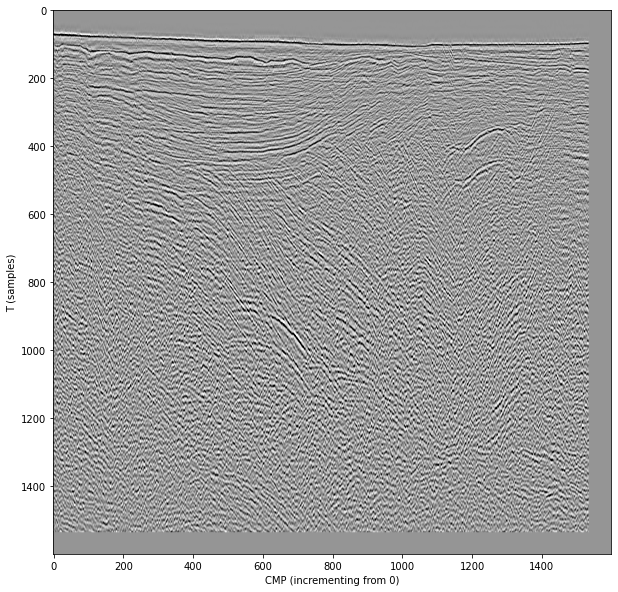

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(seis.T, cmap="Greys", vmin=-vm, vmax=vm, aspect='auto')
plt.ylabel('T (samples)')
plt.xlabel('CMP (incrementing from 0)')

In [9]:
# Reshaping traces before denoising
# seis_trc_resh = seis.reshape(seis.shape[0]*6,256)

# seis_wind_w32 = img2windows(seis,32,32)
# seis_wind_w64 = img2windows(seis,64,64)
# seis_wind_w128 = img2windows(seis,128,128)
# seis_wind_w256 = img2windows(seis,256,256)


# seis_wind_resh_w32 = seis_wind_w32.reshape(seis_wind_w32.shape[0],32,32,1)
# seis_wind_resh_w64 = seis_wind_w64.reshape(seis_wind_w64.shape[0],64,64,1)
# seis_wind_resh_w128 = seis_wind_w128.reshape(seis_wind_w128.shape[0],128,128,1)
# seis_wind_resh_w256 = seis_wind_w256.reshape(seis_wind_w256.shape[0],256,256,1)

ValueError: ignored

In [10]:
plt.imshow(seis_wind_w256[6].T,cmap='Greys')

NameError: ignored

In [11]:
def correlation_coefficient_loss(y_true, y_pred):
    #optional
    #x = y_true - y_pred
    #y = y_pred
    #mx = K.mean(x)
    #my = K.mean(y)
    #xm, ym = x-mx, y-my
    #r_num = K.sum(tf.multiply(xm,ym))
    #r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    #r = r_num / r_den
    #r =  corr1 - (K.maximum(K.minimum(r, 1.0), -1.0))
    
    #1
    x1 = y_true
    y1 = y_pred
    mx1 = K.mean(x1)
    my1 = K.mean(y1)
    xm1, ym1 = x1-mx1, y1-my1
    r_num1 = K.sum(tf.multiply(xm1,ym1))
    r_den1 = K.sqrt(tf.multiply(K.sum(K.square(xm1)), K.sum(K.square(ym1))))
    r1 = r_num1 / r_den1
    r1 = 1 -  (K.maximum(K.minimum(r1, 1.0), -1.0))
    
    # Optional
    '''  
    x2 = y_true-y_pred
    y2 = y_true
    mx2 = K.mean(x2)
    my2 = K.mean(y2)
    xm2, ym2 = x2-mx2, y2-my2
    r_num2 = K.sum(tf.multiply(xm2,ym2))
    r_den2 = K.sqrt(tf.multiply(K.sum(K.square(xm2)), K.sum(K.square(ym2))))
    r2 = r_num2 / r_den2
    r2 =    corr3 - (K.maximum(K.minimum(r2, 1.0), -1.0))
    '''
    return   K.mean(K.square(y_true - y_pred)) + r1

In [39]:
# loading pre-trained models
from tensorflow.keras.models import load_model
# modelANN_trc_SGD = load_model('./models/ANN_trc_SGD_p',compile=False)
# modelConv3x3 = load_model('./models/UpscConv3x3',compile=False)
# modelConv3x3_v2 = load_model('./models/UpscConv3x3_v2',compile=False)
# modelConv3x3_SGD = load_model('./models/UpscConv3x3_SGD',compile=False)
# modelConv3x3_v2_HF = load_model('./models/UpscConv3x3_v2_HF',compile=False)
# modelConv3x3_v2_dr_HF = load_model('./models/UpscConv3x3_v2_dr_HF',compile=False)

# modelConvUnet = load_model('./models/Unet_v1',compile=False)
# modelConvUnet_v2 = load_model('./models/Unet_v2',compile=False)
# modelConvUnet_v2_SGD = load_model('./models/Unet_v2_SGD',compile=False)

# ANN_trc_RS = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/ANN',compile=False)
# Conv3x3_RS = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3',compile=False)
# Unet_RS = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Unet',compile=False)

# Conv3x3_RS_w32 = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w32',compile=False)
# Conv3x3_RS_w64 = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w64',compile=False)
# Conv3x3_RS_w128 = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w128',compile=False)
# Conv3x3_RS_w256 = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w256',compile=False)

# Conv3x3_RS_w32_ovlp = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w32_ovlp',compile=False)

# Conv3x3_RS_w32_avg = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w32_avg',compile=False)
# Conv3x3_RS_w64_avg = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w64_avg',compile=False)
# Conv3x3_RS_w128_avg = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w128_avg',compile=False)
# Conv3x3_RS_w256_avg = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w256_avg',compile=False)

Conv3x3_RS_w32_v2 = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w32_v2',compile=False)

Unet = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Unet_v2',compile=False)



In [40]:
# modelANN_trc_SGD.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# modelConv3x3.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# modelConv3x3_v2.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# modelConv3x3_SGD.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# modelConv3x3_v2_HF.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# modelConv3x3_v2_dr_HF.compile(optimizer='adam',loss=[correlation_coefficient_loss])


# modelConvUnet.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# modelConvUnet_v2.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# modelConvUnet_v2_SGD.compile(optimizer='adam',loss=[correlation_coefficient_loss])

# ANN_trc_RS.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# Conv3x3_RS.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# Unet_RS.compile(optimizer='adam',loss=[correlation_coefficient_loss])

# Conv3x3_RS_w32.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# Conv3x3_RS_w64.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# Conv3x3_RS_w128.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# Conv3x3_RS_w256.compile(optimizer='adam',loss=[correlation_coefficient_loss])

# Conv3x3_RS_w32_ovlp.compile(optimizer='adam',loss=[correlation_coefficient_loss])


# Conv3x3_RS_w32_avg.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# Conv3x3_RS_w64_avg.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# Conv3x3_RS_w128_avg.compile(optimizer='adam',loss=[correlation_coefficient_loss])
# Conv3x3_RS_w256_avg.compile(optimizer='adam',loss=[correlation_coefficient_loss])

Conv3x3_RS_w32_v2.compile(optimizer='adam',loss=[correlation_coefficient_loss])

Unet.compile(optimizer='adam',loss=[correlation_coefficient_loss])

In [41]:
class Saver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 200 == 0 :
            self.model.save('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/epoch_models/model_{}.hd5'.format(epoch))

epoch_saver = Saver()

In [46]:
batch_size=1
epoch=5
Unet_hist = Unet.fit(seis.reshape(1,1600,1600,1),seis.reshape(1,1600,1600,1),
                                               batch_size=batch_size,
                                               epochs=epoch)
                                              #  callbacks=[epoch_saver])

Epoch 1/5
1/1 [==============================] - 0s 445ms/step - loss: 0.1538
Epoch 2/5
1/1 [==============================] - 0s 343ms/step - loss: 0.1336
Epoch 3/5
1/1 [==============================] - 0s 339ms/step - loss: 0.1181
Epoch 4/5
1/1 [==============================] - 0s 335ms/step - loss: 0.1051
Epoch 5/5
1/1 [==============================] - 0s 337ms/step - loss: 0.0947


In [ ]:
batch_size=1
epoch=1600
Conv3x3_RS_w32_v2_hist = Conv3x3_RS_w32_v2.fit(seis.reshape(1,1600,1600,1),seis.reshape(1,1600,1600,1),
                                               batch_size=batch_size,
                                               epochs=epoch,
                                               callbacks=[epoch_saver])

In [ ]:
# predConv3x3_RS = Conv3x3_RS.predict(seis_wind_resh)
# predUnet_RS = Unet_RS.predict(seis_wind_resh)
predConv3x3_RS_w32 = Conv3x3_RS_w32.predict(seis_wind_resh_w32)
predConv3x3_RS_w64 = Conv3x3_RS_w64.predict(seis_wind_resh_w64)
predConv3x3_RS_w128 = Conv3x3_RS_w128.predict(seis_wind_resh_w128)
predConv3x3_RS_w256 = Conv3x3_RS_w256.predict(seis_wind_resh_w256)

predConv3x3_RS_w32_avg = Conv3x3_RS_w32_avg.predict(seis_wind_resh_w32)
predConv3x3_RS_w64_avg = Conv3x3_RS_w64_avg.predict(seis_wind_resh_w64)
predConv3x3_RS_w128_avg = Conv3x3_RS_w128_avg.predict(seis_wind_resh_w128)
predConv3x3_RS_w256_avg = Conv3x3_RS_w256_avg.predict(seis_wind_resh_w256)

predConv3x3_RS_w32_ovlp = Conv3x3_RS_w32_ovlp.predict(seis_wind_resh_w32)


# predUnet_RS = Unet_RS.predict(seis_wind_resh)

In [ ]:
# ImgConv3x3_RS = windows2img(predConv3x3_RS.reshape(predConv3x3_RS.shape[0],32,32),1536,1536)
# ImgUnet_RS = windows2img(predUnet_RS.reshape(predUnet_RS.shape[0],32,32),1536,1536)

ImgConv3x3_RS_w32 = windows2img(predConv3x3_RS_w32.reshape(predConv3x3_RS_w32.shape[0],32,32),1536,1536)
ImgConv3x3_RS_w64 = windows2img(predConv3x3_RS_w64.reshape(predConv3x3_RS_w64.shape[0],64,64),1536,1536)
ImgConv3x3_RS_w128 = windows2img(predConv3x3_RS_w128.reshape(predConv3x3_RS_w128.shape[0],128,128),1536,1536)
ImgConv3x3_RS_w256 = windows2img(predConv3x3_RS_w256.reshape(predConv3x3_RS_w256.shape[0],256,256),1536,1536)

ImgConv3x3_RS_w32_avg = windows2img(predConv3x3_RS_w32_avg.reshape(predConv3x3_RS_w32_avg.shape[0],32,32),1536,1536)
ImgConv3x3_RS_w64_avg = windows2img(predConv3x3_RS_w64_avg.reshape(predConv3x3_RS_w64_avg.shape[0],64,64),1536,1536)
ImgConv3x3_RS_w128_avg = windows2img(predConv3x3_RS_w128_avg.reshape(predConv3x3_RS_w128_avg.shape[0],128,128),1536,1536)
ImgConv3x3_RS_w256_avg = windows2img(predConv3x3_RS_w256_avg.reshape(predConv3x3_RS_w256_avg.shape[0],256,256),1536,1536)

ImgConv3x3_RS_w32_ovlp = windows2img(predConv3x3_RS_w32_ovlp.reshape(predConv3x3_RS_w32_ovlp.shape[0],32,32),1536,1536)


# ImgUnet_RS = windows2img(predUnet_RS.reshape(predUnet_RS.shape[0],32,32),1536,1536)


# DecodedImgConv3x3_v2_HF_test = windows2img(predConv3x3_v2_HF_test.reshape(predConv3x3_v2_HF_test.shape[0],32,32),1536,1536)
# DecodedImgConv3x3_v2_dr_HF_test = windows2img(predConv3x3_v2_dr_HF_test.reshape(predConv3x3_v2_dr_HF_test.shape[0],32,32),1536,1536)

In [51]:
from tensorflow.keras.models import load_model

dir = '/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/epoch_models/'
Conv3x3_RS_v2_e0 = load_model(dir+'model_0.hd5',compile=False)
Conv3x3_RS_v2_e200 = load_model(dir+'model_200.hd5',compile=False)
Conv3x3_RS_v2_e400 = load_model(dir+'model_400.hd5',compile=False)
Conv3x3_RS_v2_e600 = load_model(dir+'model_600.hd5',compile=False)
Conv3x3_RS_v2_e800 = load_model(dir+'model_800.hd5',compile=False)
Conv3x3_RS_v2_e1000 = load_model(dir+'model_1000.hd5',compile=False)
Conv3x3_RS_v2_e1200 = load_model(dir+'model_1200.hd5',compile=False)
Conv3x3_RS_v2_e1400 = load_model(dir+'model_1400.hd5',compile=False)

In [52]:
# pred = Conv3x3_RS_w32_v2.predict(seis.reshape(1,1600,1600,1)).reshape(1600,1600)
pred_0 = Conv3x3_RS_v2_e0.predict(seis.reshape(1,1600,1600,1)).reshape(1600,1600)
pred_200 = Conv3x3_RS_v2_e200.predict(seis.reshape(1,1600,1600,1)).reshape(1600,1600)
pred_400 = Conv3x3_RS_v2_e400.predict(seis.reshape(1,1600,1600,1)).reshape(1600,1600)
pred_600 = Conv3x3_RS_v2_e600.predict(seis.reshape(1,1600,1600,1)).reshape(1600,1600)
pred_800 = Conv3x3_RS_v2_e800.predict(seis.reshape(1,1600,1600,1)).reshape(1600,1600)
pred_1000 = Conv3x3_RS_v2_e1000.predict(seis.reshape(1,1600,1600,1)).reshape(1600,1600)
pred_1200 = Conv3x3_RS_v2_e1200.predict(seis.reshape(1,1600,1600,1)).reshape(1600,1600)
pred_1400 = Conv3x3_RS_v2_e1400.predict(seis.reshape(1,1600,1600,1)).reshape(1600,1600)

In [47]:
predUnet = Unet.predict(seis.reshape(1,1600,1600,1)).reshape(1600,1600)

In [34]:
pred_1400.shape

NameError: ignored

In [57]:
xmin = 400
xmax = 600
ymin = 200
ymax = 400

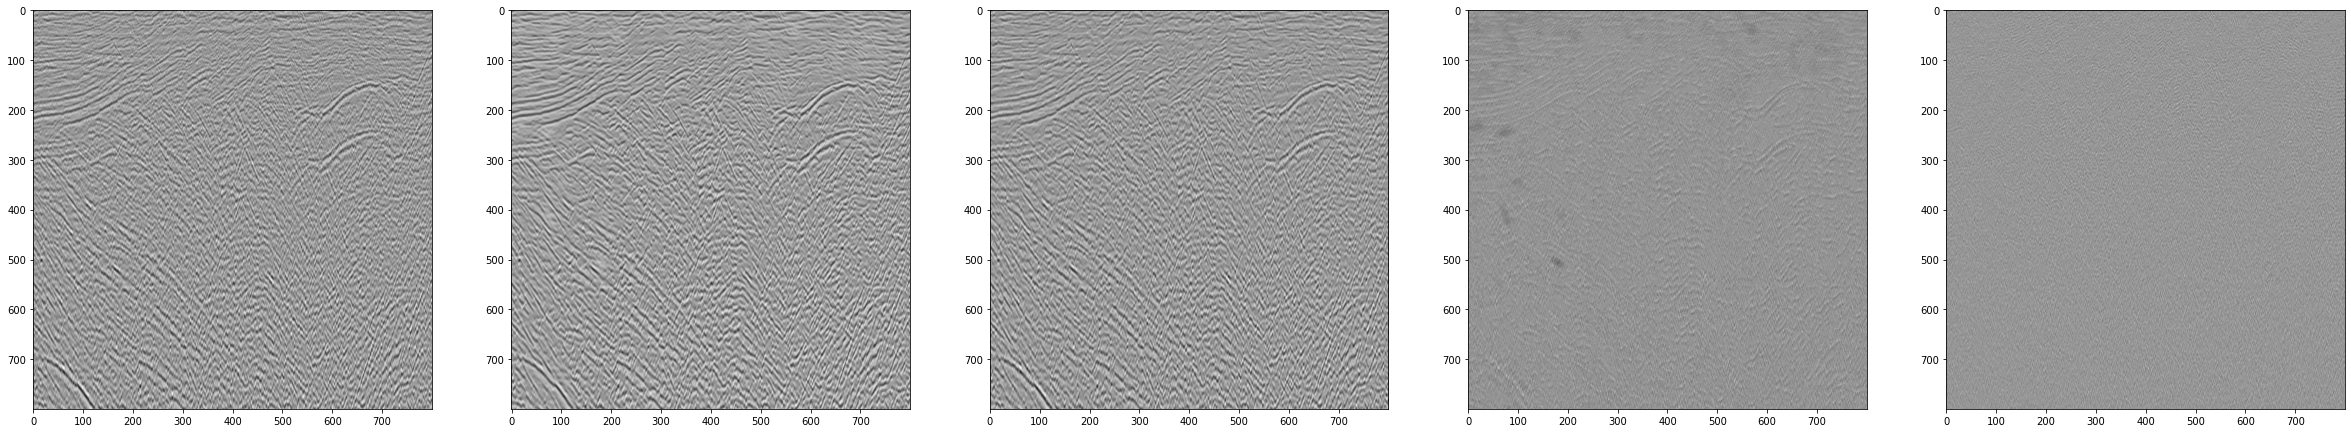

In [55]:
plt.figure(figsize=(50,30))
plt.subplot(1,6,1)
plt.imshow(seis[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')
plt.subplot(1,6,2)
plt.imshow(predUnet[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')
plt.subplot(1,6,4)
plt.imshow(seis[xmin:xmax,ymin:ymax].T-predUnet[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')
plt.subplot(1,6,5)
plt.imshow(seis[xmin:xmax,ymin:ymax].T-pred_600[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')
plt.subplot(1,6,3)
plt.imshow(pred_600[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')
# plt.subplot(1,6,6)
# plt.imshow(pred_1400[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')

NameError: ignored

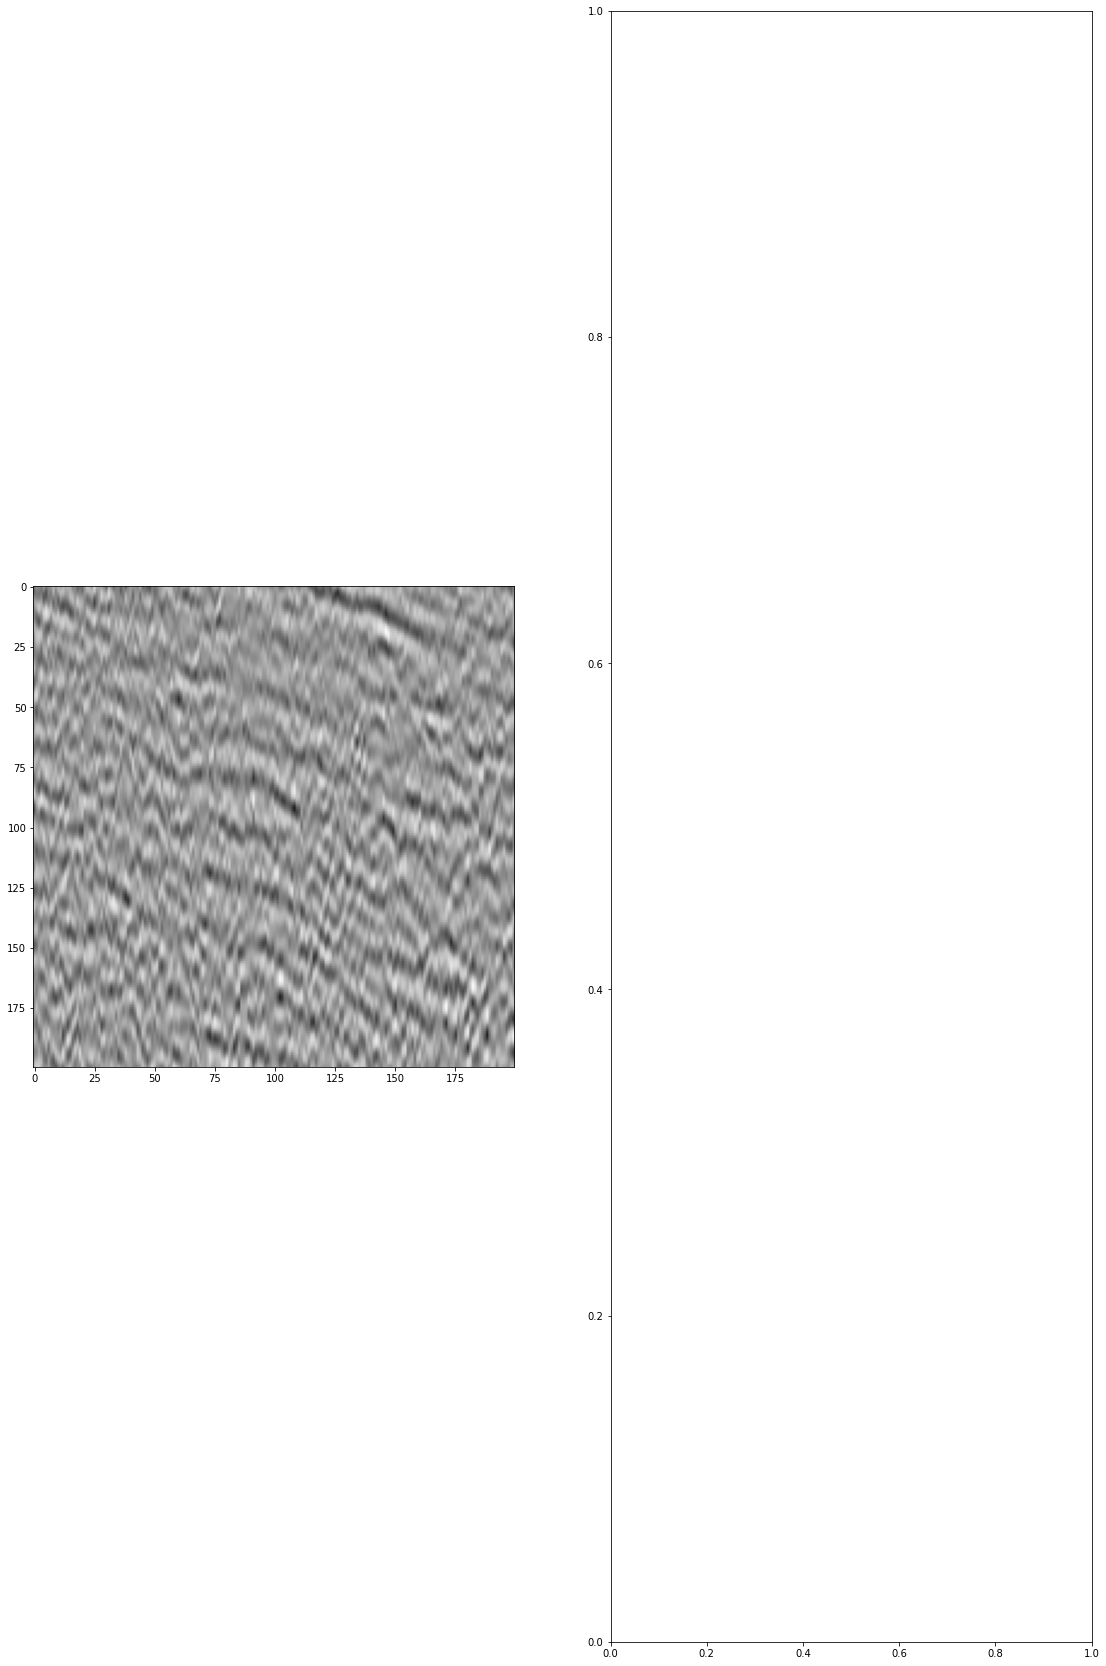

In [38]:
plt.figure(figsize=(50,30))
plt.subplot(1,5,1)
plt.imshow(seis[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')
plt.subplot(1,5,2)
plt.imshow(ImgConv3x3_RS_w32[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')
plt.subplot(1,5,3)
plt.imshow(ImgConv3x3_RS_w32_ovlp[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')
plt.subplot(1,5,4)
plt.imshow(seis[xmin:xmax,ymin:ymax].T-ImgConv3x3_RS_w32[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')
plt.subplot(1,5,5)
plt.imshow(seis[xmin:xmax,ymin:ymax].T-ImgConv3x3_RS_w32_ovlp[xmin:xmax,ymin:ymax].T,vmin=-1,vmax=1,cmap='Greys')

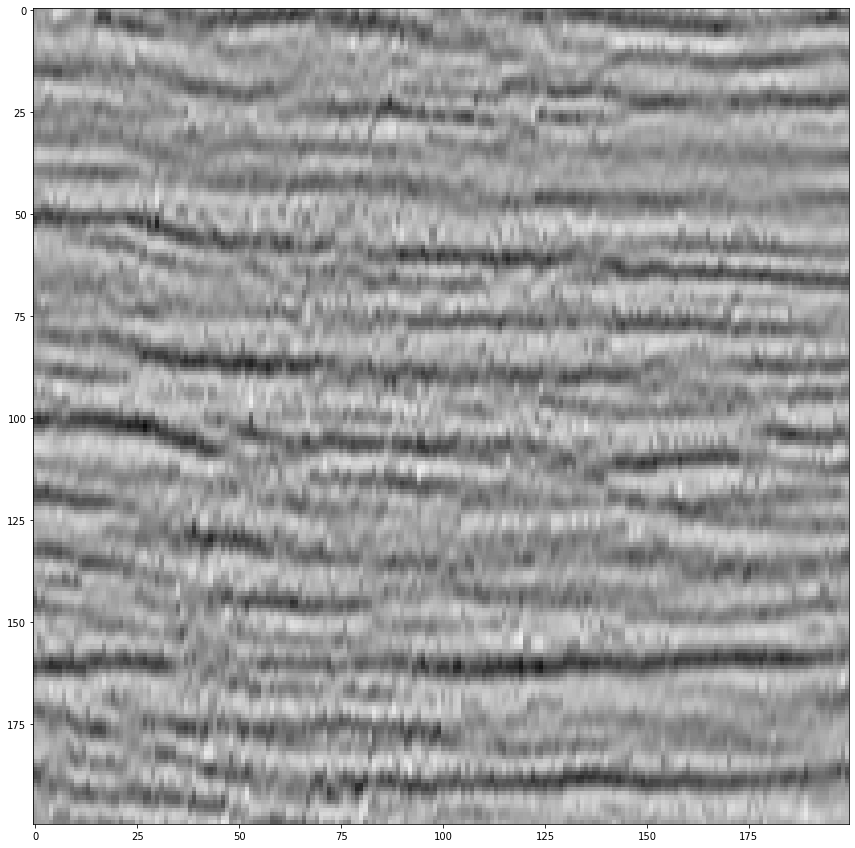

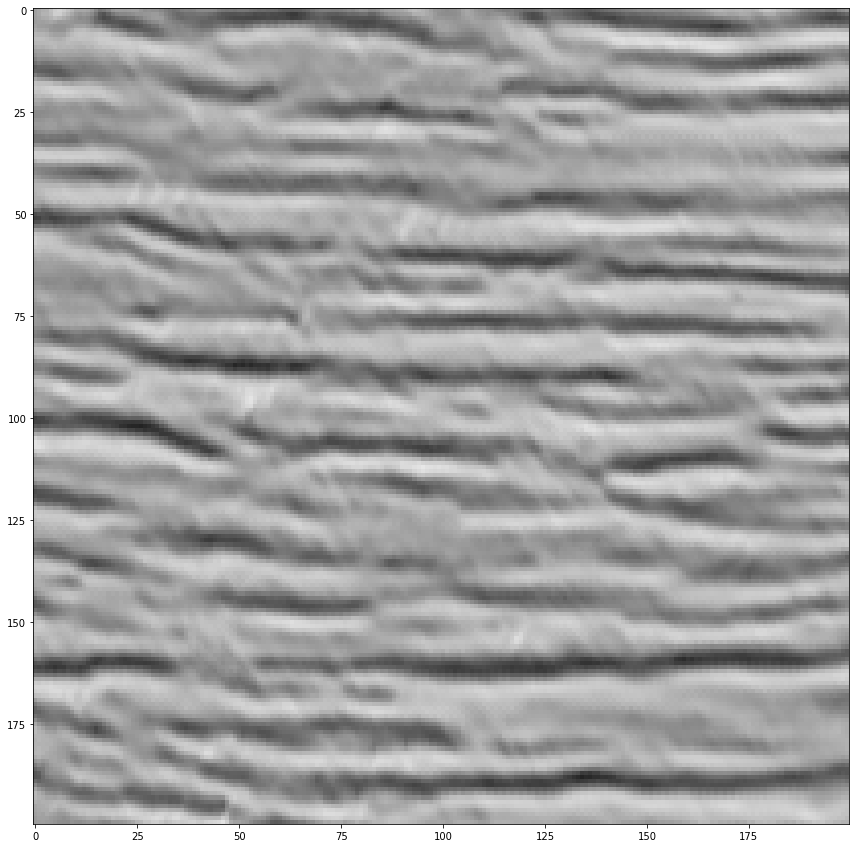

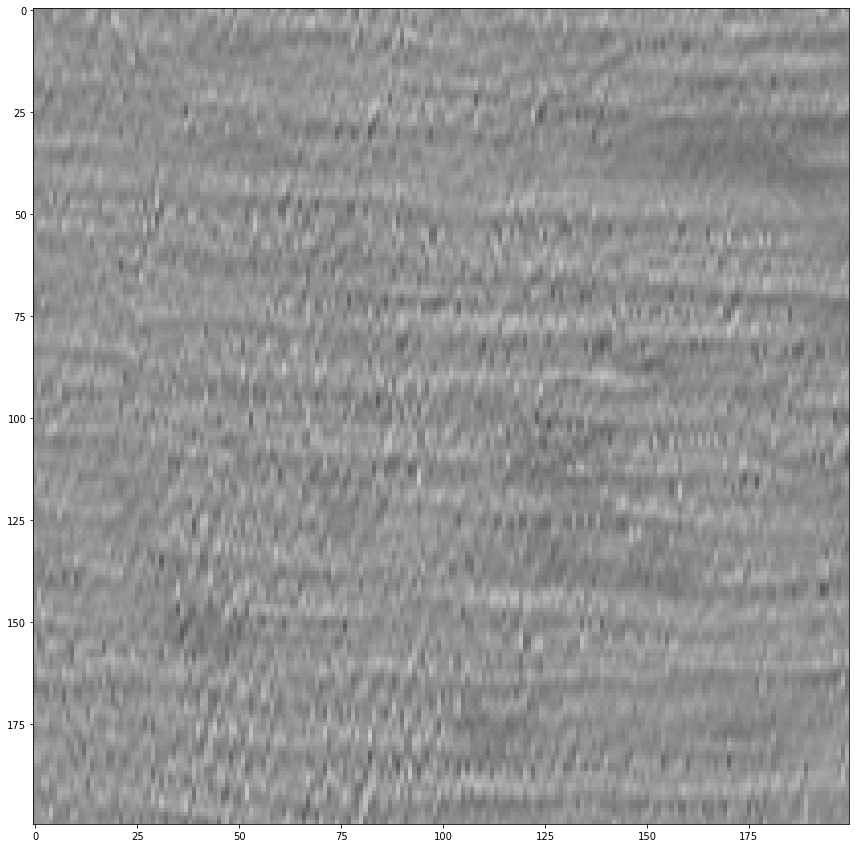

In [58]:
plt.figure(figsize=(15,15))
v =0.75
plt.imshow(seis[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/01_inp_x%s-%s_y%s-%s.png'%(xmin,xmax,ymin,ymax))

plt.figure(figsize=(15,15))
plt.imshow(predUnet[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/02_out_x%s-%s_y%s-%s_Unet_w32_full.png'%(xmin,xmax,ymin,ymax))
plt.figure(figsize=(15,15))

plt.imshow(seis[xmin:xmax,ymin:ymax].T-predUnet[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/03_diff_x%s-%s_y%s-%s_Unet_w32_full.png'%(xmin,xmax,ymin,ymax))

In [ ]:
plt.figure(figsize=(15,15))
v =0.75
plt.imshow(seis[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/01_inp_x%s-%s_y%s-%s.png'%(xmin,xmax,ymin,ymax))

plt.figure(figsize=(15,15))
plt.imshow(pred_1200[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/02_out_x%s-%s_y%s-%s_Conv3x3_RS_w32_full_1200.png'%(xmin,xmax,ymin,ymax))
plt.figure(figsize=(15,15))

plt.imshow(seis[xmin:xmax,ymin:ymax].T-pred_1200[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/03_diff_x%s-%s_y%s-%s_Conv3x3_RS_w32_full_1200.png'%(xmin,xmax,ymin,ymax))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.figure(figsize=(15,15))
v =0.75
plt.imshow(seis[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/01_inp_x%s-%s_y%s-%s.png'%(xmin,xmax,ymin,ymax))

plt.figure(figsize=(15,15))
plt.imshow(pred_1000[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/02_out_x%s-%s_y%s-%s_Conv3x3_RS_w32_full_1000.png'%(xmin,xmax,ymin,ymax))
plt.figure(figsize=(15,15))

plt.imshow(seis[xmin:xmax,ymin:ymax].T-pred_1000[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/03_diff_x%s-%s_y%s-%s_Conv3x3_RS_w32_full_1000.png'%(xmin,xmax,ymin,ymax))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.figure(figsize=(15,15))
v =0.75
plt.imshow(seis[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/01_inp_x%s-%s_y%s-%s.png'%(xmin,xmax,ymin,ymax))

plt.figure(figsize=(15,15))
plt.imshow(pred_800[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/02_out_x%s-%s_y%s-%s_Conv3x3_RS_w32_full_800.png'%(xmin,xmax,ymin,ymax))
plt.figure(figsize=(15,15))

plt.imshow(seis[xmin:xmax,ymin:ymax].T-pred_800[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/03_diff_x%s-%s_y%s-%s_Conv3x3_RS_w32_full_800.png'%(xmin,xmax,ymin,ymax))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.figure(figsize=(15,15))
v =0.75
plt.imshow(seis[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/01_inp_x%s-%s_y%s-%s.png'%(xmin,xmax,ymin,ymax))

plt.figure(figsize=(15,15))
plt.imshow(pred_600[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/02_out_x%s-%s_y%s-%s_Conv3x3_RS_w32_full_600.png'%(xmin,xmax,ymin,ymax))
plt.figure(figsize=(15,15))

plt.imshow(seis[xmin:xmax,ymin:ymax].T-pred_600[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/03_diff_x%s-%s_y%s-%s_Conv3x3_RS_w32_full_600.png'%(xmin,xmax,ymin,ymax))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.figure(figsize=(15,15))
v =0.75
plt.imshow(seis[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/01_inp_x%s-%s_y%s-%s.png'%(xmin,xmax,ymin,ymax))

plt.figure(figsize=(15,15))
plt.imshow(pred_400[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/02_out_x%s-%s_y%s-%s_Conv3x3_RS_w32_full_400.png'%(xmin,xmax,ymin,ymax))
plt.figure(figsize=(15,15))

plt.imshow(seis[xmin:xmax,ymin:ymax].T-pred_400[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/03_diff_x%s-%s_y%s-%s_Conv3x3_RS_w32_full_400.png'%(xmin,xmax,ymin,ymax))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.figure(figsize=(15,15))
v =0.75
plt.imshow(seis[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/01_inp_x%s-%s_y%s-%s.png'%(xmin,xmax,ymin,ymax))

plt.figure(figsize=(15,15))
plt.imshow(pred_200[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/02_out_x%s-%s_y%s-%s_Conv3x3_RS_w32_full_200.png'%(xmin,xmax,ymin,ymax))
plt.figure(figsize=(15,15))

plt.imshow(seis[xmin:xmax,ymin:ymax].T-pred_200[xmin:xmax,ymin:ymax].T,vmin=-v,vmax=v,cmap='Greys')
plt.savefig('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/results/images/03_diff_x%s-%s_y%s-%s_Conv3x3_RS_w32_full_200.png'%(xmin,xmax,ymin,ymax))

Output hidden; open in https://colab.research.google.com to view.